In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support,classification_report

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import (Dense, Input, LSTM, Embedding,
                          Dropout, Activation)
from keras.layers import (Bidirectional, GlobalMaxPool1D,
                         Conv1D, SimpleRNN, Dense, Input, 
                        Flatten, Dropout, BatchNormalization,MaxPooling1D)
from keras.models import Model,Sequential

Using TensorFlow backend.


In [4]:
from helper import load_data, token

In [5]:

%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.style.use('fivethirtyeight') # plt.style.available

In [6]:
stops = joblib.load('../stops.pkl')

Loading data ...
Droping 10 rows with features lenght of less than 2
Droping 3 as rating and setting 1-2 as negative(0), 4-5 as positive(1))
{1: 460527, 0: 127232} 

Down sampling positive ratings to match negatives
Data loading completed
{1: 127232, 0: 127232} 

Execution Time: 6 seconds


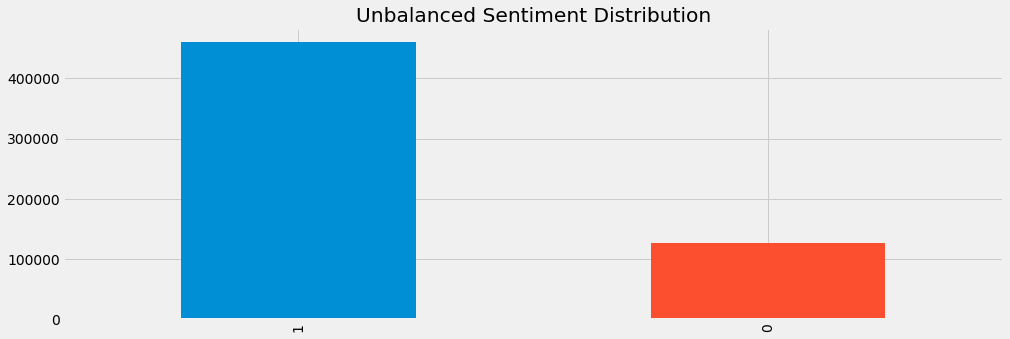

In [14]:
df = load_data('../sentiment_data', balanced=True)

In [8]:
df.head()

,features,target,y
0,Internetkøb med postleverance på under 24 time...,5,1
1,Let og hurtig behandling af erstatning. \r\nMe...,5,1
2,Venlig og hurtig betjening,5,1
3,Super hurtig og effektiv forsendelse lige til ...,5,1
4,"Nemt at bestille, hurtig levering og varen er ...",5,1


In [16]:
train, test = train_test_split(df, test_size=.2)

### Sequence lenghts, max number of words and embedding dimmensions

In [17]:
%%time
MAX_SEQUENCE_LENGTH = 300 # if less pad zeros if more truncate
MAX_NB_WORDS = 1800 # get 18000 most frequent words
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,oov_token=token)
tokenizer.fit_on_texts(train.features)
train_sequences = tokenizer.texts_to_sequences(train.features)
test_sequences = tokenizer.texts_to_sequences(test.features)

# our dictionary
word_index = tokenizer.word_index

CPU times: user 35 s, sys: 328 ms, total: 35.4 s
Wall time: 36 s


In [18]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [19]:
le = LabelEncoder()
le.fit(train['y'])
train_labels = le.transform(train['y'])
test_labels = le.transform(test['y'])

# changing data types
labels_train = to_categorical(np.asarray(train_labels))
labels_test = to_categorical(np.asarray(test_labels))

# Training CNN 1D model

In [20]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])

In [21]:
start_time = pd.datetime.now()
#  5 epochs and with batch size of 64 patterns
model.fit(train_data, labels_train, batch_size=64, 
          epochs=5, validation_data=(test_data, labels_test))

Train on 203571 samples, validate on 50893 samples
Epoch 1/5
203571/203571 [==============================] - 669s 3ms/step - loss: 0.2443 - acc: 0.9088 - val_loss: 0.1878 - val_acc: 0.9312
Epoch 2/5
203571/203571 [==============================] - 685s 3ms/step - loss: 0.1969 - acc: 0.9281 - val_loss: 0.1766 - val_acc: 0.9349
Epoch 3/5
203571/203571 [==============================] - 697s 3ms/step - loss: 0.1888 - acc: 0.9314 - val_loss: 0.1770 - val_acc: 0.9350
Epoch 4/5
203571/203571 [==============================] - 724s 4ms/step - loss: 0.1859 - acc: 0.9333 - val_loss: 0.1675 - val_acc: 0.9383
Epoch 5/5
203571/203571 [==============================] - 739s 4ms/step - loss: 0.1843 - acc: 0.9347 - val_loss: 0.1680 - val_acc: 0.9390


In [22]:
print(f'Model took {pd.datetime.now()-start_time} to train')
predicted=model.predict(test_data)

Model took 0:58:34.415447 to train


In [23]:
precision, recall, fscore, support = precision_recall_fscore_support(labels_test,predicted.round())
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'fscore: {fscore}')
print(f'support: {support}')

print(classification_report(labels_test,predicted.round()))

precision: [0.93995982 0.9380635 ]
recall: [0.93789064 0.94012729]
fscore: [0.93892409 0.93909426]
support: [25439 25454]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     25439
           1       0.94      0.94      0.94     25454

   micro avg       0.94      0.94      0.94     50893
   macro avg       0.94      0.94      0.94     50893
weighted avg       0.94      0.94      0.94     50893
 samples avg       0.94      0.94      0.94     50893



## RNN

In [26]:
model_1 = Sequential()
model_1.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_1.add(SimpleRNN(2, input_shape=(None,1)))
model_1.add(Dense(2,activation='softmax'))
model_1.compile(loss = 'binary_crossentropy',optimizer='adam',metrics = ['accuracy'])

In [ ]:
start_time = pd.datetime.now()
model_1.fit(train_data, labels_train, batch_size=16, epochs=5,
          validation_data=(test_data, labels_test))

Train on 203571 samples, validate on 50893 samples
Epoch 1/5
203571/203571 [==============================] - 1535s 8ms/step - loss: 0.2537 - acc: 0.9084 - val_loss: 0.2099 - val_acc: 0.9264
Epoch 2/5
203571/203571 [==============================] - 1761s 9ms/step - loss: 0.2013 - acc: 0.9280 - val_loss: 0.1940 - val_acc: 0.9318
Epoch 3/5
 59024/203571 [=======>......................] - ETA: 14:21 - loss: 0.1856 - acc: 0.9355

In [ ]:
print(f'Model took {pd.datetime.now()-start_time} to train')
pred_rnn=model_1.predict(test_data)

precision, recall, fscore, support = precision_recall_fscore_support(labels_test,pred_rnn.round())
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'fscore: {fscore}')
print(f'support: {support}')

print(classification_report(labels_test,pred_rnn.round()))

## LSTM

In [ ]:
model_2 = Sequential()
model_2.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH))
model_2.add(LSTM(output_dim=16, activation='relu', inner_activation='hard_sigmoid',return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(BatchNormalization())
model_2.add(Flatten())
model_2.add(Dense(2,activation='softmax'))
model_2.compile(loss = 'binary_crossentropy',optimizer='adam',metrics = ['accuracy'])

In [ ]:
start_time = pd.datetime.now()
model_2.fit(train_data, labels_train, batch_size=16, epochs=5,
          validation_data=(test_data, labels_test))

203571/203571 [==============================] - 6122s 30ms/step - loss: 0.2095 - acc: 0.9225 - val_loss: 0.1731 - val_acc: 0.9360
Epoch 2/5
203571/203571 [==============================] - 6202s 30ms/step - loss: 0.1706 - acc: 0.9376 - val_loss: 0.1600 - val_acc: 0.9423
Epoch 3/5
203571/203571 [==============================] - 6191s 30ms/step - loss: 0.1512 - acc: 0.9451 - val_loss: 0.1536 - val_acc: 0.9456
Epoch 4/5
203571/203571 [==============================] - 6188s 30ms/step - loss: 0.1366 - acc: 0.9507 - val_loss: 0.1500 - val_acc: 0.9475
Epoch 5/5
 43712/203571 [=====>........................] - ETA: 1:18:11 - loss: 0.1222 - acc: 0.9561

In [ ]:
print(f'Model took {pd.datetime.now()-start_time} to train')
pred_lstm=model_2.predict(test_data)

precision, recall, fscore, support = precision_recall_fscore_support(labels_test,pred_lstm.round())
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'fscore: {fscore}')
print(f'support: {support}')

print(classification_report(labels_test,pred_lstm.round()))

## Bidirectional LSTM

In [ ]:
model_3 = Sequential()
model_3.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH))
model_3.add(Bidirectional(LSTM(16, return_sequences=True,dropout=0.1, recurrent_dropout=0.1)))
model_3.add(Conv1D(16, kernel_size = 3, padding = "valid",kernel_initializer = "glorot_uniform"))
model_3.add(GlobalMaxPool1D())
model_3.add(Dense(50, activation="relu"))
model_3.add(Dropout(0.1))
model_3.add(Dense(2,activation='softmax'))
model_3.compile(loss = 'binary_crossentropy',optimizer='adam',metrics = ['accuracy'])

In [ ]:
start_time = pd.datetime.now()
model_3.fit(train_data, labels_train,batch_size=16,epochs=3,
          validation_data=(test_data, labels_test))

In [ ]:
print(f'Model took {pd.datetime.now()-start_time} to train')
pred_blstm=model_3.predict(test_data)

precision, recall, fscore, support = precision_recall_fscore_support(labels_test,pred_blstm.round())
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'fscore: {fscore}')
print(f'support: {support}')

print(classification_report(labels_test,pred_blstm.round()))